<a href="https://colab.research.google.com/github/glorivaas/Risk_Measures/blob/main/PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **FINAL PROJECT**
# **American Option Portfolio Value-at-Risk (VaR)**

### **INTRODUCTION**
  ▶ What is an **option**?
  
  An option is a financial contract that gives someone the right (but not the obligation) to buy or sell something in the future, like a stock.

  - A call option = right to buy

  - A put option = right to sell


▶ What is an **American Option**?

There are two main types:

  - European option: can only be exercised at the end

  - American option: can be exercised at any time before or on the expiration date


▶  Why are American Options **harder to value**?

Because we do not know when the holder will choose to exercise it. We need a smart way to decide if holding the option is better than using it right now.


▶  We introduce: **Longstaff-Schwartz Algorithm**

This algorithm helps us estimate the best time to exercise an American option.
It works like this:
  
  1. Simulate multiple price paths for the underlying stock.

  2. At each time step, calculate:

    - The immediate payoff from exercising

    - The expected value of holding it longer (using regression)

    - Exercise the option if it is better than holding it.

  3. Repeat for many paths and average results to estimate the option’s value.

▶ **Portfolio** VaR calculation

We will follow this steps in this project:

  1. Simulating portfolio values under many market conditions.

  2. Calculating the distribution of possible profits and losses (P&L).

  3. Taking the 5th percentile (for 95% VaR) — this is the estimated worst loss.

**DATA**:

We will use SPY ticker, because:

- It’s a real security

- You can get actual option prices for validation

- American options exist and trade on SPY (but not on ^GSPC)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


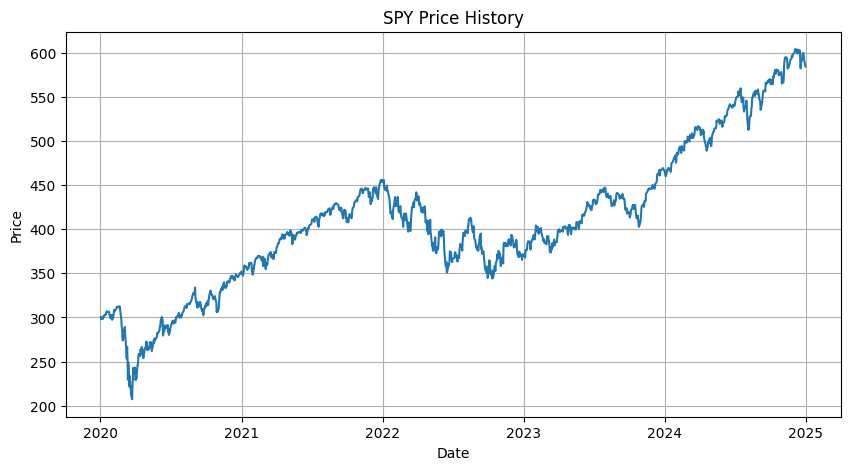

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ticker = 'SPY'
start_date = '2020-01-01'
end_date = '2025-01-01'

spy_data = yf.download(ticker, start=start_date, end=end_date)
spy_data = spy_data[['Close']].rename(columns={'Close': 'Price'})

plt.figure(figsize=(10, 5))
plt.plot(spy_data.index, spy_data['Price'])
plt.title('SPY Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


Annualized Mean Return (mu): 0.1335
Annualized Volatility (sigma): 0.2108


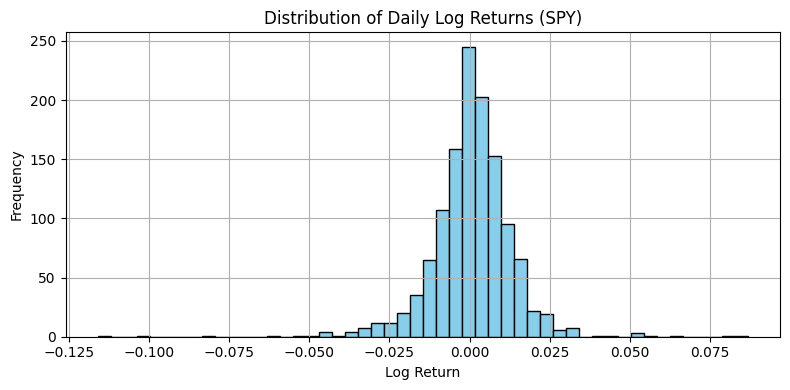

In [2]:
spy_data['LogReturn'] = np.log(spy_data['Price'] / spy_data['Price'].shift(1))
spy_data.dropna(inplace=True)

mu_daily = spy_data['LogReturn'].mean()
sigma_daily = spy_data['LogReturn'].std()

mu_annual = mu_daily * 252
sigma_annual = sigma_daily * np.sqrt(252)

print(f"Annualized Mean Return (mu): {mu_annual:.4f}")
print(f"Annualized Volatility (sigma): {sigma_annual:.4f}")

plt.figure(figsize=(8, 4))
plt.hist(spy_data['LogReturn'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Daily Log Returns (SPY)")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

#**PRELIMINAR ANALYSIS**
On the one hand, a mean return of aprox 13.35% is a reasonable average annual return as the long term average for the S&P 500 is usually around 7%–10% (after inflation). Also some recent 5-year windows (like post-COVID recovery) have been higher — so 13% is very plausible.

On the other hand, volatility is of aprox 21.08%. This is also a realistic result, as SPY's volatility usually ranges between 15%–25% annually. Events like COVID crash (2020), inflation spikes (2022) and tech growth rebound (2023–2024) all contribute to volatility in your 5-year window.

#**IMPLEMENTATION**
**Monte Carlo Simulation (using GBM)**

We simulate future asset prices by generating multiple random paths based on the Geometric Brownian Motion (GBM) model:

$$
S_{t+\Delta t} = S_t \cdot \exp\left[ \left( r - q - \frac{1}{2} \sigma^2 \right) \Delta t + \sigma \sqrt{\Delta t} \cdot Z_t \right]
$$

Where:
- $ S_t $: asset price at time $ t $
- $ r $: risk-free interest rate
- $ q $: continuous dividend yield
- $ \sigma $: volatility
- $ \Delta t $: time step (1/252 for daily simulation)
- $ Z_t \sim \mathcal{N}(0, 1) $: standard normal random variable

This method generates multiple possible price paths to estimate the future distribution of asset prices.

<br>

**European Call Option (Black-Scholes Formula)**

Under the Black-Scholes model with continuous dividend yield $q$, the price of a European call option is given by:

$$
C = S_0 e^{-qT} N(d_1) - K e^{-rT} N(d_2)
$$

Where:

$$
d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + (r - q + \frac{1}{2} \sigma^2)T}{\sigma \sqrt{T}}, \quad
d_2 = d_1 - \sigma \sqrt{T}
$$


<br>

**European Put Option (Put-Call Parity with Dividends)**

Instead of directly using the Black-Scholes formula, we use:

$$
P = C + K e^{-rT} - S_0 e^{-qT}
$$

Where $C$ is the price of the corresponding European call.


<br>

**American Option Pricing (Longstaff-Schwartz Method)**

The Longstaff-Schwartz algorithm is used to estimate the price of American options by simulating price paths and using backward induction with least-squares regression to estimate continuation values.


At each time step $t$, for each path where the option is in-the-money:

$$
V_t = \max \left( h_t(S_t), \mathbb{E}[V_{t+1} \mid S_t] \right)
$$

where:
- $h_t(S_t)$: the immediate (intrinsic) payoff, e.g. $\max(K - S_t, 0)$ for a put
- $\mathbb{E}[V_{t+1} \mid S_t]$: the estimated continuation value


In [3]:
import numpy as np
import scipy.stats as sts
from typing import Tuple


class MonteCarloOptionPricing:
    def __init__(self, r, S0: float, K: float, T: float, sigma: float, div_yield: float = 0.0,
                 simulation_rounds: int = 10000, no_of_slices: int = 4, fix_random_seed: bool or int = False):
        """
        S0: current price of the underlying asset (e.g. stock)
        K: exercise price
        T: time to maturity, in years, a float number
        r: interest rate, by default we assume constant interest rate model
        sigma: volatility (in standard deviation) of the asset annual returns
        div_yield: annual dividend yield
        simulation_rounds: in general, monte carlo option pricing requires many simulations
        no_of_slices: between time 0 and time T, the number of slices PER YEAR, e.g. 252 if trading days are required
        fix_random_seed: boolean or integer

        """
        self.S0 = float(S0)
        self.K = float(K)
        self.T = float(T)
        self.div_yield = float(div_yield)

        self.no_of_slices = int(no_of_slices)
        self.simulation_rounds = int(simulation_rounds)

        self._dt = self.T / self.no_of_slices

        self.mue = r  # under risk-neutral measure, asset expected return = risk-free rate
        self.r = np.full((self.simulation_rounds, self.no_of_slices), r * self._dt)
        self.discount_table = np.exp(np.cumsum(-self.r, axis=1))

        self.sigma = np.full((self.simulation_rounds, self.no_of_slices), sigma)

        self.terminal_prices = []

        self.z_t = np.random.standard_normal((self.simulation_rounds, self.no_of_slices))

        if type(fix_random_seed) is bool:
            if fix_random_seed:
                np.random.seed(15000)
        elif type(fix_random_seed) is int:
            np.random.seed(fix_random_seed)


    def stock_price_simulation(self) -> np.ndarray:
        self.exp_mean = (self.mue - self.div_yield - (self.sigma ** 2.0) * 0.5) * self._dt
        self.exp_diffusion = self.sigma * np.sqrt(self._dt)

        self.price_array = np.zeros((self.simulation_rounds, self.no_of_slices))
        self.price_array[:, 0] = self.S0

        for i in range(1, self.no_of_slices):
            self.price_array[:, i] = self.price_array[:, i - 1] * np.exp(
                self.exp_mean[:, i - 1] + self.exp_diffusion[:, i - 1] * self.z_t[:, i - 1]
            )

        self.terminal_prices = self.price_array[:, -1]
        self.stock_price_expectation = np.average(self.terminal_prices)

        print('-' * 64)
        print(
            " Number of simulations %4.1i \n S0 %4.1f \n K %2.1f \n Maximum Stock price %4.2f \n"
            " Minimum Stock price %4.2f \n Average stock price %4.3f " % (
                self.simulation_rounds, self.S0, self.K, np.max(self.terminal_prices),
                np.min(self.terminal_prices), self.stock_price_expectation
            )
        )
        print('-' * 64)

        return self.stock_price_expectation

    def european_call(self) -> Tuple[float, float]:
        assert len(self.terminal_prices) != 0

        self.terminal_profit = np.maximum((self.terminal_prices - self.K), 0.0)

        self.expectation = np.average(self.terminal_profit * np.exp(-np.sum(self.r, axis=1)))

        print('-' * 64)
        print(
            " European call monte carlo \n S0 %4.1f \n K %2.1f \n"
            " Call Option Value %4.3f \n " % (
                self.S0, self.K, self.expectation
            )
        )
        print('-' * 64)

        return self.expectation

    def european_put(self, empirical_call: float or None = None) -> float:

        if empirical_call is None:
            self.european_call_value = self.european_call()
        else:
            self.european_call_value = empirical_call

        self.put_value = self.european_call_value + np.exp(-np.sum(self.r, axis=1)) * self.K - np.exp(
            -self.div_yield * self.T) * self.S0

        return self.put_value


    def american_option_longstaff_schwartz(self, poly_degree: int = 2, option_type: str = 'call') -> float:
        """
        poly_degree: degree of polynomial for regression (default=2)
        option_type: 'call' or 'put'

        """
        # Compute intrinsic value
        if option_type == 'call':
            self.intrinsic_val = np.maximum(self.price_array - self.K, 0.0)
        else:
            self.intrinsic_val = np.maximum(self.K - self.price_array, 0.0)

        # Final cashflow = intrinsic value at maturity
        cf = self.intrinsic_val[:, -1]
        stopping_rule = np.zeros_like(self.price_array)
        stopping_rule[:, -1] = (cf > 0).astype(int)

        # Track which paths have already exercised
        exercised = np.zeros(self.simulation_rounds, dtype=bool)

        # Backward induction
        for t in range(self.no_of_slices - 2, 0, -1):
            # Discount cashflows only for paths still alive
            cf[~exercised] *= np.exp(-self.r[~exercised, t + 1])

            itm_path = np.where((self.intrinsic_val[:, t] > 0) & (~exercised))[0]
            if len(itm_path) > 5:
                Y = cf[itm_path]
                X = self.price_array[itm_path, t]
                coeffs = np.polyfit(X, Y, deg=poly_degree)
                continuation_val = np.polyval(coeffs, X)
            else:
                continuation_val = np.zeros(len(itm_path))

            # Compare continuation value vs. immediate exercise
            exercise_now = self.intrinsic_val[itm_path, t] > (continuation_val + 1e-6)
            exercised_indices = itm_path[exercise_now]

            # Update cashflows and stopping rule for exercised paths
            cf[exercised_indices] = self.intrinsic_val[exercised_indices, t]
            exercised[exercised_indices] = True
            stopping_rule[exercised_indices, t] = 1
            stopping_rule[exercised_indices, t + 1:] = 0

        # Calculate discounted payoff
        simulation_vals = (self.intrinsic_val * stopping_rule * self.discount_table).sum(axis=1)
        self.expectation = np.mean(simulation_vals)

        print('-' * 64)
        print(
            f" American {option_type} Longstaff-Schwartz pricing\n"
            f" Polynomial degree = {poly_degree}\n"
            f" S0 = {self.S0:.2f}, K = {self.K:.2f}, Value = {self.expectation:.4f}"
        )
        print('-' * 64)

        return self.expectation

# **Example** of paths generator using GBM

In [4]:
engine = MonteCarloOptionPricing(
    r=0.05,
    S0=584.32,
    K=600,
    T=1,
    sigma=0.30,
    div_yield=0.015,
    simulation_rounds=1000,
    no_of_slices=252,
    fix_random_seed=True
)

engine.stock_price_simulation()

paths_df = pd.DataFrame(engine.price_array.T)
paths_df.columns = [f'Path_{i}' for i in range(paths_df.shape[1])]
paths_df.index.name = "TimeStep"

print(paths_df.head())

----------------------------------------------------------------
 Number of simulations 1000 
 S0 584.3 
 K 600.0 
 Maximum Stock price 1433.34 
 Minimum Stock price 257.58 
 Average stock price 598.261 
----------------------------------------------------------------
              Path_0      Path_1      Path_2      Path_3      Path_4  \
TimeStep                                                               
0         584.320000  584.320000  584.320000  584.320000  584.320000   
1         584.660020  571.514069  573.347053  583.289507  568.834240   
2         570.416359  577.219840  589.520497  584.582383  570.648463   
3         562.780738  569.873254  593.589386  581.245888  551.196610   
4         555.772241  583.574129  603.144043  571.042092  533.045527   

              Path_5      Path_6      Path_7      Path_8      Path_9  ...  \
TimeStep                                                              ...   
0         584.320000  584.320000  584.320000  584.320000  584.320000  ..

# **EXPERIMENT 1: Call Options looping over different strike prices**

----------------------------------------------------------------
 Number of simulations 50000 
 S0 584.3 
 K 560.0 
 Maximum Stock price 1344.46 
 Minimum Stock price 222.74 
 Average stock price 601.858 
----------------------------------------------------------------
----------------------------------------------------------------
 European call monte carlo 
 S0 584.3 
 K 560.0 
 Call Option Value 69.044 
 
----------------------------------------------------------------
----------------------------------------------------------------
 American call Longstaff-Schwartz pricing
 Polynomial degree = 2
 S0 = 584.32, K = 560.00, Value = 71.8045
----------------------------------------------------------------
----------------------------------------------------------------
 Number of simulations 50000 
 S0 584.3 
 K 570.0 
 Maximum Stock price 1572.38 
 Minimum Stock price 208.57 
 Average stock price 601.527 
----------------------------------------------------------------
---------------

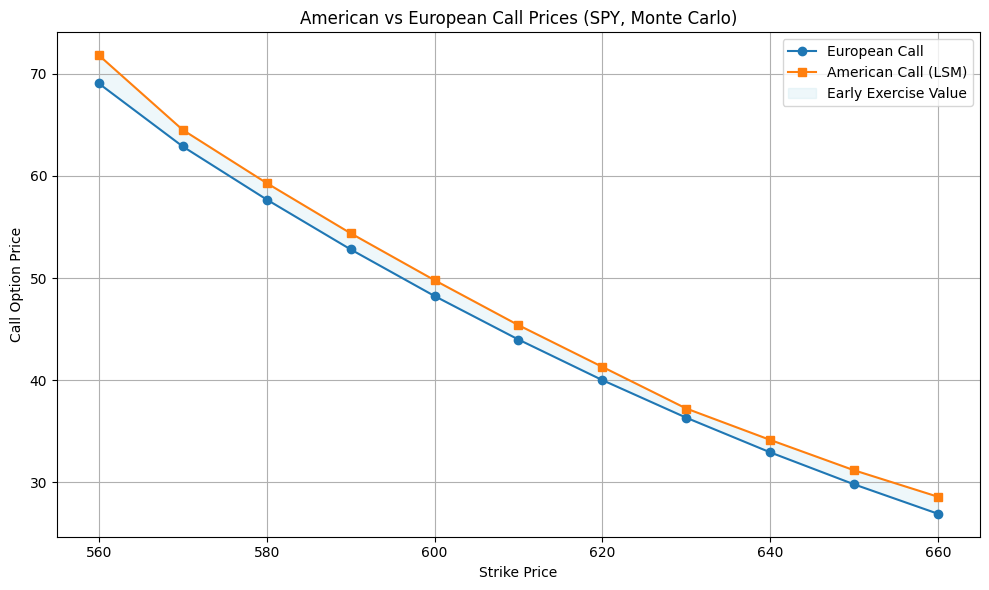

In [5]:
import numpy as np
import matplotlib.pyplot as plt

S0 = spy_data['Price'].iloc[-1]
S0 = S0.values[0]
T = 1
r = 0.05
sigma = sigma_annual
div_yield = 0.02
sim_rounds = 50000
time_slices = 252

# === Strike range ===
strike_range = np.arange(560, 670, 10)

european_calls = []
american_calls = []

# === Loop over strikes ===
for K in strike_range:
    # Create new engine for each K
    engine = MonteCarloOptionPricing(
        r=r, S0=S0, K=K, T=T, sigma=sigma,
        div_yield=div_yield,
        simulation_rounds=sim_rounds,
        no_of_slices=time_slices,
        fix_random_seed=42
    )

    # Simulate once per option
    engine.stock_price_simulation()

    # European call
    euro = engine.european_call()
    european_calls.append(euro)

    # American call
    amer = engine.american_option_longstaff_schwartz(poly_degree=2, option_type='call')
    american_calls.append(amer)

# Convert to arrays
european_calls = np.array(european_calls)
american_calls = np.array(american_calls)

# === Plotting ===
plt.figure(figsize=(10, 6))
plt.plot(strike_range, european_calls, label='European Call', marker='o')
plt.plot(strike_range, american_calls, label='American Call (LSM)', marker='s')
plt.fill_between(strike_range, european_calls, american_calls, alpha=0.2, color='lightblue', label='Early Exercise Value')
plt.xlabel("Strike Price")
plt.ylabel("Call Option Price")
plt.title("American vs European Call Prices (SPY, Monte Carlo)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# **ANALYSIS**
We can notice that american call prices are slightly higher than European call prices, which is theoretically correct because SPY pays dividends. That means that if you own the stock, you get the dividend payout.

However, the gap is small for all strikes, reflecting the fact that SPY’s dividend yield (1.5%) is not large enough to make early exercise dramatically more valuable.

Other characteristic we can observe is a larger early exercise value for lower strikes, like 560, showingthe biggest gap between American and European calls.
This is due to the fact that these options are more likely to be exercised early to capture dividends.

# **EXPERIMENT 2: Put Options looping over different volatilities**

----------------------------------------------------------------
 Number of simulations 50000 
 S0 584.3 
 K 600.0 
 Maximum Stock price 959.26 
 Minimum Stock price 367.99 
 Average stock price 604.837 
----------------------------------------------------------------
----------------------------------------------------------------
 European call monte carlo 
 S0 584.3 
 K 600.0 
 Call Option Value 25.012 
 
----------------------------------------------------------------
----------------------------------------------------------------
 American put Longstaff-Schwartz pricing
 Polynomial degree = 2
 S0 = 584.32, K = 600.00, Value = 21.8685
----------------------------------------------------------------
----------------------------------------------------------------
 Number of simulations 50000 
 S0 584.3 
 K 600.0 
 Maximum Stock price 1297.91 
 Minimum Stock price 235.85 
 Average stock price 604.867 
----------------------------------------------------------------
-----------------

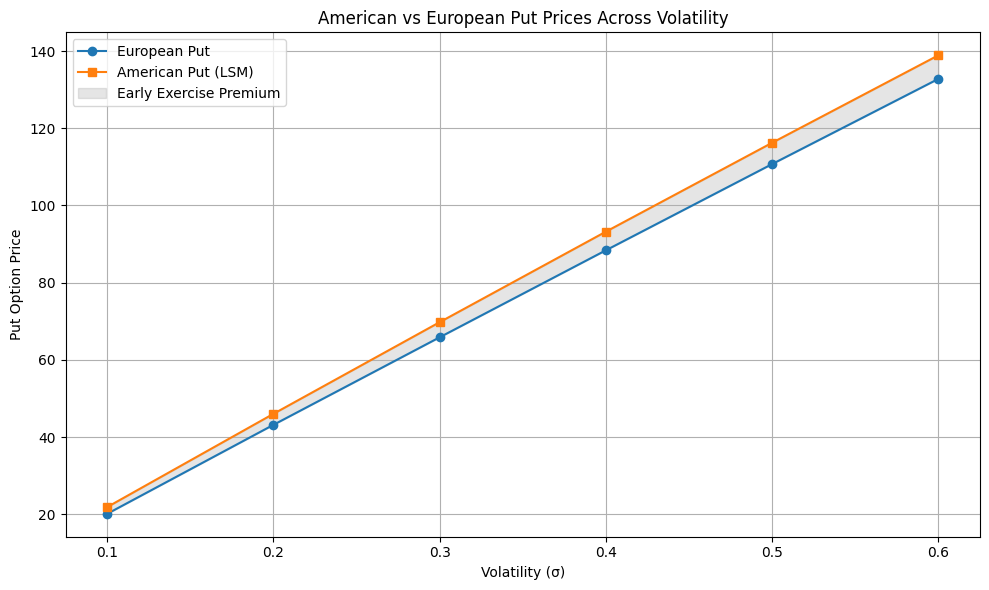

In [6]:
S0 = spy_data['Price'].iloc[-1]
S0 = S0.values[0]
K = 600
T = 1
r = 0.05
div_yield = 0.015
sim_rounds = 50000
time_slices = 252

# Range of volatilities to test
vol_range = np.linspace(0.1, 0.6, 6)

european_puts = []
american_puts = []

for sigma in vol_range:
    engine = MonteCarloOptionPricing(
        r=r,
        S0=S0,
        K=K,
        T=T,
        sigma=sigma,
        div_yield=div_yield,
        simulation_rounds=sim_rounds,
        no_of_slices=time_slices,
        fix_random_seed=True
    )

    engine.stock_price_simulation()
    european_puts.append(np.mean(engine.european_put()))
    american_puts.append(engine.american_option_longstaff_schwartz(poly_degree=2, option_type='put'))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(vol_range, european_puts, marker='o', label='European Put')
plt.plot(vol_range, american_puts, marker='s', label='American Put (LSM)')
plt.fill_between(vol_range, european_puts, american_puts, alpha=0.2, color='gray', label='Early Exercise Premium')
plt.xlabel('Volatility (σ)')
plt.ylabel('Put Option Price')
plt.title('American vs European Put Prices Across Volatility')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# **ANALYSIS**
First we can see that put option prices increase with volatility as it increases uncertainty, which increases the value of having downside protection (for puts). Also, we can notice that early exercise premium increases with this sensivity, beacuse there are more situations where the holder may want to exercise early.
For puts, this is especially true when the stock drops sharply (deep in-the-money).

This is the main conclusion of this experiment, it demonstrates that early exercise flexibility becomes more valuable in volatile markets.

# **EXPERIMENTS 3 AND 4: Effect of dividend yield and time to maturity on call prices**

----------------------------------------------------------------
 Number of simulations 50000 
 S0 584.3 
 K 500.0 
 Maximum Stock price 5379.34 
 Minimum Stock price 32.28 
 Average stock price 614.098 
----------------------------------------------------------------
----------------------------------------------------------------
 European call monte carlo 
 S0 584.3 
 K 500.0 
 Call Option Value 186.338 
 
----------------------------------------------------------------
----------------------------------------------------------------
 American call Longstaff-Schwartz pricing
 Polynomial degree = 2
 S0 = 584.32, K = 500.00, Value = 194.5343
----------------------------------------------------------------
----------------------------------------------------------------
 Number of simulations 50000 
 S0 584.3 
 K 500.0 
 Maximum Stock price 5118.00 
 Minimum Stock price 30.71 
 Average stock price 584.264 
----------------------------------------------------------------
---------------

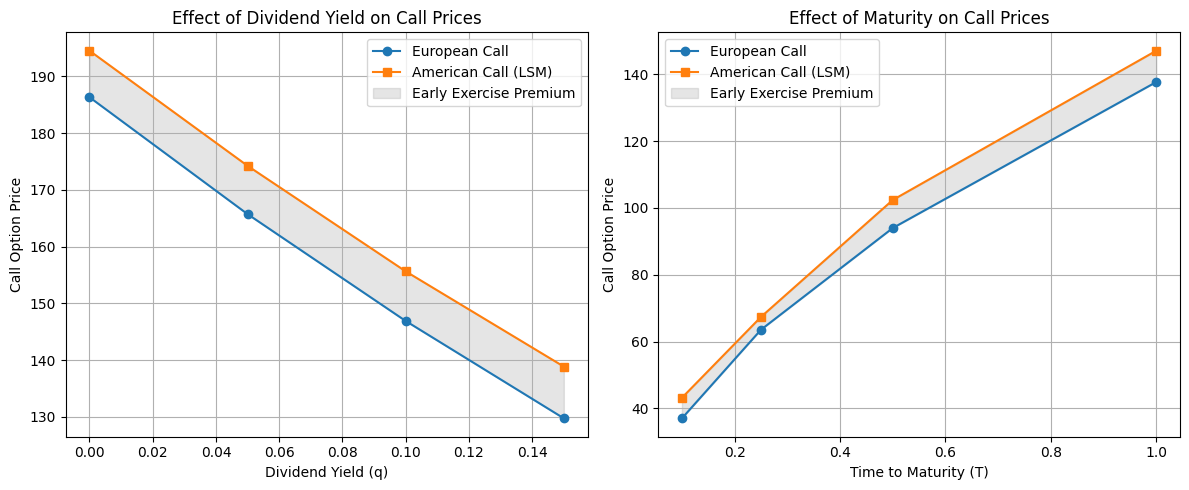

In [19]:
slices = 252
dividends = [0.0, 0.05, 0.10, 0.15]
euro_divs = []
amer_divs = []


for q in dividends:
    engine = MonteCarloOptionPricing(
        r=r, S0=S0, K=500, T=1, sigma=sigma,
        div_yield=q,
        simulation_rounds=sim_rounds,
        no_of_slices=slices,
        fix_random_seed=True,
    )
    engine.stock_price_simulation()
    euro = engine.european_call()
    amer = engine.american_option_longstaff_schwartz(poly_degree=2, option_type='call')
    euro_divs.append(euro)
    amer_divs.append(amer)
    div_diffs = np.array(amer_divs) - np.array(euro_divs)

print("\nFull premium per dividend:")
for q, diff in zip(dividends, div_diffs):
    print(f"q = {q:.2%} → premium = {diff:.4f}")

maturities = [0.1, 0.25, 0.5, 1.0]
euro_times = []
amer_times = []

for T in maturities:
    engine = MonteCarloOptionPricing(
        r=r, S0=S0, K=K, T=T, sigma=sigma,
        div_yield=0.015,
        simulation_rounds=sim_rounds,
        no_of_slices=int(slices * T),
        fix_random_seed=True
    )
    engine.stock_price_simulation()
    euro = engine.european_call()
    amer = engine.american_option_longstaff_schwartz(poly_degree=2, option_type='call')
    euro_times.append(euro)
    amer_times.append(amer)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(dividends, euro_divs, label='European Call', marker='o')
axs[0].plot(dividends, amer_divs, label='American Call (LSM)', marker='s')
axs[0].fill_between(dividends, euro_divs, amer_divs, alpha=0.2, color='gray', label='Early Exercise Premium')
axs[0].set_xlabel("Dividend Yield (q)")
axs[0].set_ylabel("Call Option Price")
axs[0].set_title("Effect of Dividend Yield on Call Prices")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(maturities, euro_times, label='European Call', marker='o')
axs[1].plot(maturities, amer_times, label='American Call (LSM)', marker='s')
axs[1].fill_between(maturities, euro_times, amer_times, alpha=0.2, color='gray', label='Early Exercise Premium')
axs[1].set_xlabel("Time to Maturity (T)")
axs[1].set_ylabel("Call Option Price")
axs[1].set_title("Effect of Maturity on Call Prices")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

# **ANALYSIS**
- For the plot about effect of dividends, we can observe that higher dividends increase the incentive to exercise early (to receive the dividend), so the American call becomes more valuable relative to the European call. Maybe this is not very noticeable, but we have that for 0 dividends the early exercise value is 8.20, while for dividends of 15% is 9.12, so it is slowly growing.

- For the one on different times to maturity, we have that both American and European call prices increase with longer maturity; this is expected, as more time equals more optionality. That is also why the early exercise premium also grows slightly.

# **Final conclusions**
- American options are consistently more valuable than European options due to the early exercise feature.
- For calls, the early exercise premium grows primarily with dividend yield and time to maturity.
- For puts, the premium grows more with volatility and moneyness.
- The Longstaff-Schwartz method successfully captures this behavior.
- This validates our Monte Carlo pricing implementation under real SPY market conditions.


# **REFERENCES**
[1] Glasserman, Monte Carlo Methods in Financial Engineering, Ch. 8

[2] Palczewski, Computational Finance Lecture Notes, Ch. 8

[3] McNeil, Frey, Embrechts, Quantitative Risk Management (for risk metrics background)

[4] “Valuing American Options by Simulation: A Simple Least-Squares Approach” Francis Longstaff and Eduardo Schwartz, Review of Financial Studies, 2001.